Importing libraries and data files

In [462]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from lightgbm import plot_importance



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 20)

/kaggle/input/janatahack-crosssell-prediction/test.csv
/kaggle/input/janatahack-crosssell-prediction/sample_submission.csv
/kaggle/input/janatahack-crosssell-prediction/train.csv


In [463]:
train = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/train.csv',index_col=0)
test = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/test.csv',index_col=0)
sample_submission = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/sample_submission.csv',index_col=0)

In [464]:
train[['Driving_License','Previously_Insured','Policy_Sales_Channel','Region_Code']] = train[['Driving_License','Previously_Insured','Policy_Sales_Channel','Region_Code']].astype('object')
train['Response'] = train['Response'].astype('object')

test[['Driving_License','Previously_Insured','Policy_Sales_Channel','Region_Code']] = test[['Driving_License','Previously_Insured','Policy_Sales_Channel','Region_Code']].astype('object')

Treating outliers

In [465]:
premium_median = train['Annual_Premium'].median()
train['Annual_Premium'] = np.where(train['Annual_Premium']> 100000.000000, premium_median, train['Annual_Premium'])

In [466]:
premium_median_test = test['Annual_Premium'].median()
test['Annual_Premium'] = np.where(test['Annual_Premium']> 100000.000000, premium_median_test, test['Annual_Premium'])

Feature engineering

In [467]:
train['Vehicle_Age_Damage'] = train['Vehicle_Age'] + '_' + train['Vehicle_Damage']
test['Vehicle_Age_Damage'] = test['Vehicle_Age'] + '_' + test['Vehicle_Damage']

In [468]:
train['Premium_sqrt'] = np.sqrt(train['Annual_Premium'])
test['Premium_sqrt'] = np.sqrt(test['Annual_Premium'])

In [469]:
train['Region_Count'] = train.groupby('Region_Code')['Region_Code'].transform('count')
test['Region_Count'] = test.groupby('Region_Code')['Region_Code'].transform('count')

In [470]:
train['Channel_Count'] = train.groupby('Policy_Sales_Channel')['Policy_Sales_Channel'].transform('count')
test['Channel_Count'] = test.groupby('Policy_Sales_Channel')['Policy_Sales_Channel'].transform('count')

In [471]:
train['Premium_mean'] = train.groupby('Annual_Premium')['Annual_Premium'].transform('mean')
test['Premium_mean'] = test.groupby('Annual_Premium')['Annual_Premium'].transform('mean')

In [472]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_Damage,Premium_sqrt,Region_Count,Channel_Count,Premium_mean
id,,,,,,,,,,,,,,,,
1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1,> 2 Years_Yes,201.131798,106415,79700,40454.0
2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0,1-2 Year_No,183.128370,9251,79700,33536.0
3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1,> 2 Years_Yes,195.688528,106415,79700,38294.0
4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0,< 1 Year_No,169.171511,9232,134784,28619.0
5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0,< 1 Year_No,165.819179,18263,134784,27496.0


In [473]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_Damage,Premium_sqrt,Region_Count,Channel_Count,Premium_mean
id,,,,,,,,,,,,,,,
381110,Male,25,1,11,1,< 1 Year,No,35786.0,152,53,< 1 Year_No,189.171880,3096,44739,35786.0
381111,Male,40,1,28,0,1-2 Year,Yes,33762.0,7,111,1-2 Year_Yes,183.744388,35522,559,33762.0
381112,Male,47,1,28,0,1-2 Year,Yes,40050.0,124,199,1-2 Year_Yes,200.124961,35522,24304,40050.0
381113,Male,24,1,27,1,< 1 Year,Yes,37356.0,152,187,< 1 Year_Yes,193.277003,888,44739,37356.0
381114,Male,27,1,28,1,< 1 Year,No,59097.0,152,297,< 1 Year_No,243.098745,35522,44739,59097.0


Data pre-processing

In [474]:
X = train.drop('Response',axis=1)
# imp_cols = ['Gender','Age', 'Driving_License', 'Previously_Insured','Vehicle_Damage','Annual_Premium',
#        'Vintage','Vehicle_Age_Damage','Policy_Sales_Channel'] 
# X = train[imp_cols]
# test = test[imp_cols]
y = train['Response'].values

In [475]:
#Scaling numeric variables

sc = StandardScaler()
X[X.select_dtypes(exclude='object').columns.to_list()] = sc.fit_transform(X.select_dtypes(exclude='object'))

In [477]:
test[test.select_dtypes(exclude='object').columns.to_list()] = sc.transform(test.select_dtypes(exclude='object'))

In [478]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_Damage,Premium_sqrt,Region_Count,Channel_Count,Premium_mean
id,,,,,,,,,,,,,,,
1,Male,0.333777,1,28,0,> 2 Years,Yes,0.631395,26,0.748795,> 2 Years_Yes,0.641350,1.576430,-0.023951,0.631395
2,Male,2.396751,1,3,0,1-2 Year,No,0.199979,26,0.342443,1-2 Year_No,0.325767,-0.667688,-0.023951,0.199979
3,Male,0.527181,1,28,0,> 2 Years,Yes,0.496695,26,-1.521998,> 2 Years_Yes,0.545934,1.576430,-0.023951,0.496695
4,Male,-1.148985,1,11,1,< 1 Year,No,-0.106651,152,0.581474,< 1 Year_No,0.081116,-0.668126,1.121200,-0.106651
5,Female,-0.633242,1,41,1,< 1 Year,No,-0.176683,152,-1.378580,< 1 Year_No,0.022353,-0.459545,1.121200,-0.176683


In [479]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_Damage,Premium_sqrt,Region_Count,Channel_Count,Premium_mean
id,,,,,,,,,,,,,,,
381110,Male,-0.891113,1,11,1,< 1 Year,No,0.340293,152,-1.211258,< 1 Year_No,0.431704,-0.809845,-0.750761,0.340293
381111,Male,0.075906,1,28,0,1-2 Year,Yes,0.214073,7,-0.518068,1-2 Year_Yes,0.336565,-0.060928,-1.669226,0.214073
381112,Male,0.527181,1,28,0,1-2 Year,Yes,0.606201,124,0.533668,1-2 Year_Yes,0.623701,-0.060928,-1.175588,0.606201
381113,Male,-0.955581,1,27,1,< 1 Year,Yes,0.438200,152,0.390249,< 1 Year_Yes,0.503663,-0.860841,-0.750761,0.438200
381114,Male,-0.762177,1,28,1,< 1 Year,No,1.793998,152,1.704919,< 1 Year_No,1.376991,-0.060928,-0.750761,1.793998


In [480]:
#Encoding categorical variables

X = pd.get_dummies(X,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [481]:
le = LabelEncoder()
y = le.fit_transform(y)

Training the model

In [482]:
clf = LGBMClassifier(n_estimators=550,
                     learning_rate=0.03,
                     min_child_samples=40,
                     random_state=1,
                     colsample_bytree=0.5,
                     reg_alpha=2,
                     reg_lambda=2)

clf.fit(X, y, verbose=50,eval_metric = 'auc')

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.03, min_child_samples=40,
               n_estimators=550, random_state=1, reg_alpha=2, reg_lambda=2)

In [483]:
lgb_pred = clf.predict_proba(X)[:,1]
roc_auc_score(y,lgb_pred)

0.8657519447897326

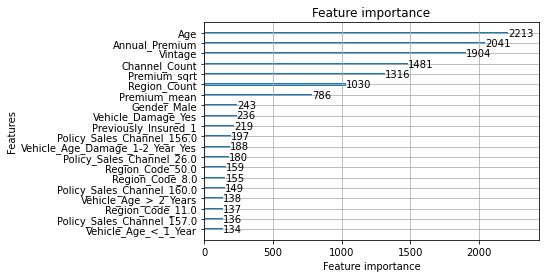

In [484]:
plot_importance(clf,max_num_features=20);

Pre-processing test data and predicting probabilities

In [485]:
print(test.shape,X.shape)

missing_cols = set(X.columns) - set(test.columns)
for c in missing_cols:
    test[c] = 0

print(test.shape,X.shape)

#keeping the order of columns same for X and test
test = test[X.columns]

(127037, 214) (381109, 224)
(127037, 226) (381109, 224)


In [486]:
test_pred = clf.predict_proba(test)[:,1]

In [257]:
sample_submission['Response'] = test_pred
sample_submission.to_csv('Submission_v6.csv')